In [130]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession
from google.cloud import storage
from pyspark.sql.functions import lit
from functools import reduce
from pyspark.sql import DataFrame
from pyspark.sql.functions import *
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
spark = SparkSession.builder.appName('Nifty50').getOrCreate()

#change configuration settings on Spark 
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '30g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','30g'), ("spark.driver.maxResultSize", "70g")])

gcs_client = storage.Client()

In [3]:
bucket_name = 'bigdata_nifty50'

In [4]:
bucket = gcs_client.bucket(bucket_name)

In [5]:
file_name = 'combined.csv'

In [6]:
df = spark.read.csv('gs://{}//{}'.format(bucket_name, file_name), inferSchema=True)

In [7]:
new_columns = ['date',
 'close',
 'high',
 'low',
 'open',
 'volume',
 'sma5',
 'sma10',
 'sma15',
 'sma20',
 'ema5',
 'ema10',
 'ema15',
 'ema20',
 'upperband',
 'middleband',
 'lowerband',
 'HT_TRENDLINE',
 'KAMA10',
 'KAMA20',
 'KAMA30',
 'SAR',
 'TRIMA5',
 'TRIMA10',
 'TRIMA20',
 'ADX5',
 'ADX10',
 'ADX20',
 'APO',
 'CCI5',
 'CCI10',
 'CCI15',
 'macd510',
 'macd520',
 'macd1020',
 'macd1520',
 'macd1226',
 'MFI',
 'MOM10',
 'MOM15',
 'MOM20',
 'ROC5',
 'ROC10',
 'ROC20',
 'PPO',
 'RSI14',
 'RSI8',
 'slowk',
 'slowd',
 'fastk',
 'fastd',
 'fastksr',
 'fastdsr',
 'ULTOSC',
 'WILLR',
 'ATR',
 'Trange',
 'TYPPRICE',
 'HT_DCPERIOD',
 'BETA',
 'sector',
 'company']

In [8]:
 from functools import reduce

 old_columns = df.schema.names

 df = reduce(lambda data, idx: data.withColumnRenamed(old_columns[idx], new_columns[idx]), range(len(old_columns)), df)
 df.printSchema()

root
 |-- date: timestamp (nullable = true)
 |-- close: double (nullable = true)
 |-- high: double (nullable = true)
 |-- low: double (nullable = true)
 |-- open: double (nullable = true)
 |-- volume: integer (nullable = true)
 |-- sma5: double (nullable = true)
 |-- sma10: double (nullable = true)
 |-- sma15: double (nullable = true)
 |-- sma20: double (nullable = true)
 |-- ema5: double (nullable = true)
 |-- ema10: double (nullable = true)
 |-- ema15: double (nullable = true)
 |-- ema20: double (nullable = true)
 |-- upperband: double (nullable = true)
 |-- middleband: double (nullable = true)
 |-- lowerband: double (nullable = true)
 |-- HT_TRENDLINE: double (nullable = true)
 |-- KAMA10: double (nullable = true)
 |-- KAMA20: double (nullable = true)
 |-- KAMA30: double (nullable = true)
 |-- SAR: double (nullable = true)
 |-- TRIMA5: double (nullable = true)
 |-- TRIMA10: double (nullable = true)
 |-- TRIMA20: double (nullable = true)
 |-- ADX5: double (nullable = true)
 |-- ADX10

In [11]:
df.describe().show()

+-------+------------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+--------------------+--------------------+--------------------+------------------+------------------+------------------+------------------+------------------+--------------------+------------------+------------------+-------------------+-------------------+-------------------+--------------------+-------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+--------------------+------------------+------------------+--------------------+--------------------+----

In [29]:
df.select(approxCountDistinct("sector", rsd = 0.01)).show()

+-----------------------------+
|approx_count_distinct(sector)|
+-----------------------------+
|                           19|
+-----------------------------+



# Check for Null Values and Duplicates

In [30]:
df.select([count(when(df[c].isNull(), c)).alias(c) for c in df.columns]).show()

+----+-----+----+---+----+------+----+-----+-----+-----+----+-----+-----+-----+---------+----------+---------+------------+------+------+------+---+------+-------+-------+----+-----+-----+---+----+-----+-----+-------+-------+--------+--------+--------+---+-----+-----+-----+----+-----+-----+---+-----+----+-----+-----+-----+-----+-------+-------+------+-----+---+------+--------+-----------+----+------+-------+
|date|close|high|low|open|volume|sma5|sma10|sma15|sma20|ema5|ema10|ema15|ema20|upperband|middleband|lowerband|HT_TRENDLINE|KAMA10|KAMA20|KAMA30|SAR|TRIMA5|TRIMA10|TRIMA20|ADX5|ADX10|ADX20|APO|CCI5|CCI10|CCI15|macd510|macd520|macd1020|macd1520|macd1226|MFI|MOM10|MOM15|MOM20|ROC5|ROC10|ROC20|PPO|RSI14|RSI8|slowk|slowd|fastk|fastd|fastksr|fastdsr|ULTOSC|WILLR|ATR|Trange|TYPPRICE|HT_DCPERIOD|BETA|sector|company|
+----+-----+----+---+----+------+----+-----+-----+-----+----+-----+-----+-----+---------+----------+---------+------------+------+------+------+---+------+-------+-------+----+

In [253]:
num_columns = df.columns
num_columns.remove('company')
num_columns.remove('sector')
num_columns.remove('date')
num_columns.remove('month')
df.select([count(when(isnan(c), c)).alias(c) for c in num_columns]).show()

+-----+----+---+----+------+----+-----+-----+-----+----+-----+-----+-----+---------+----------+---------+------------+------+------+------+---+------+-------+-------+----+-----+-----+---+----+-----+-----+-------+-------+--------+--------+--------+---+-----+-----+-----+----+-----+-----+---+-----+----+-----+-----+-----+-----+-------+-------+------+-----+---+------+--------+-----------+----+
|close|high|low|open|volume|sma5|sma10|sma15|sma20|ema5|ema10|ema15|ema20|upperband|middleband|lowerband|HT_TRENDLINE|KAMA10|KAMA20|KAMA30|SAR|TRIMA5|TRIMA10|TRIMA20|ADX5|ADX10|ADX20|APO|CCI5|CCI10|CCI15|macd510|macd520|macd1020|macd1520|macd1226|MFI|MOM10|MOM15|MOM20|ROC5|ROC10|ROC20|PPO|RSI14|RSI8|slowk|slowd|fastk|fastd|fastksr|fastdsr|ULTOSC|WILLR|ATR|Trange|TYPPRICE|HT_DCPERIOD|BETA|
+-----+----+---+----+------+----+-----+-----+-----+----+-----+-----+-----+---------+----------+---------+------------+------+------+------+---+------+-------+-------+----+-----+-----+---+----+-----+-----+-------+----

In [35]:
df.count()

63944373

In [32]:
df.dropna().count()

63944373

In [33]:
df.dropDuplicates().count()

63944373

In [12]:
max_close_df = df.groupby(df.company).agg(max(df.close)).toPandas()

<AxesSubplot:xlabel='max(close)', ylabel='company'>

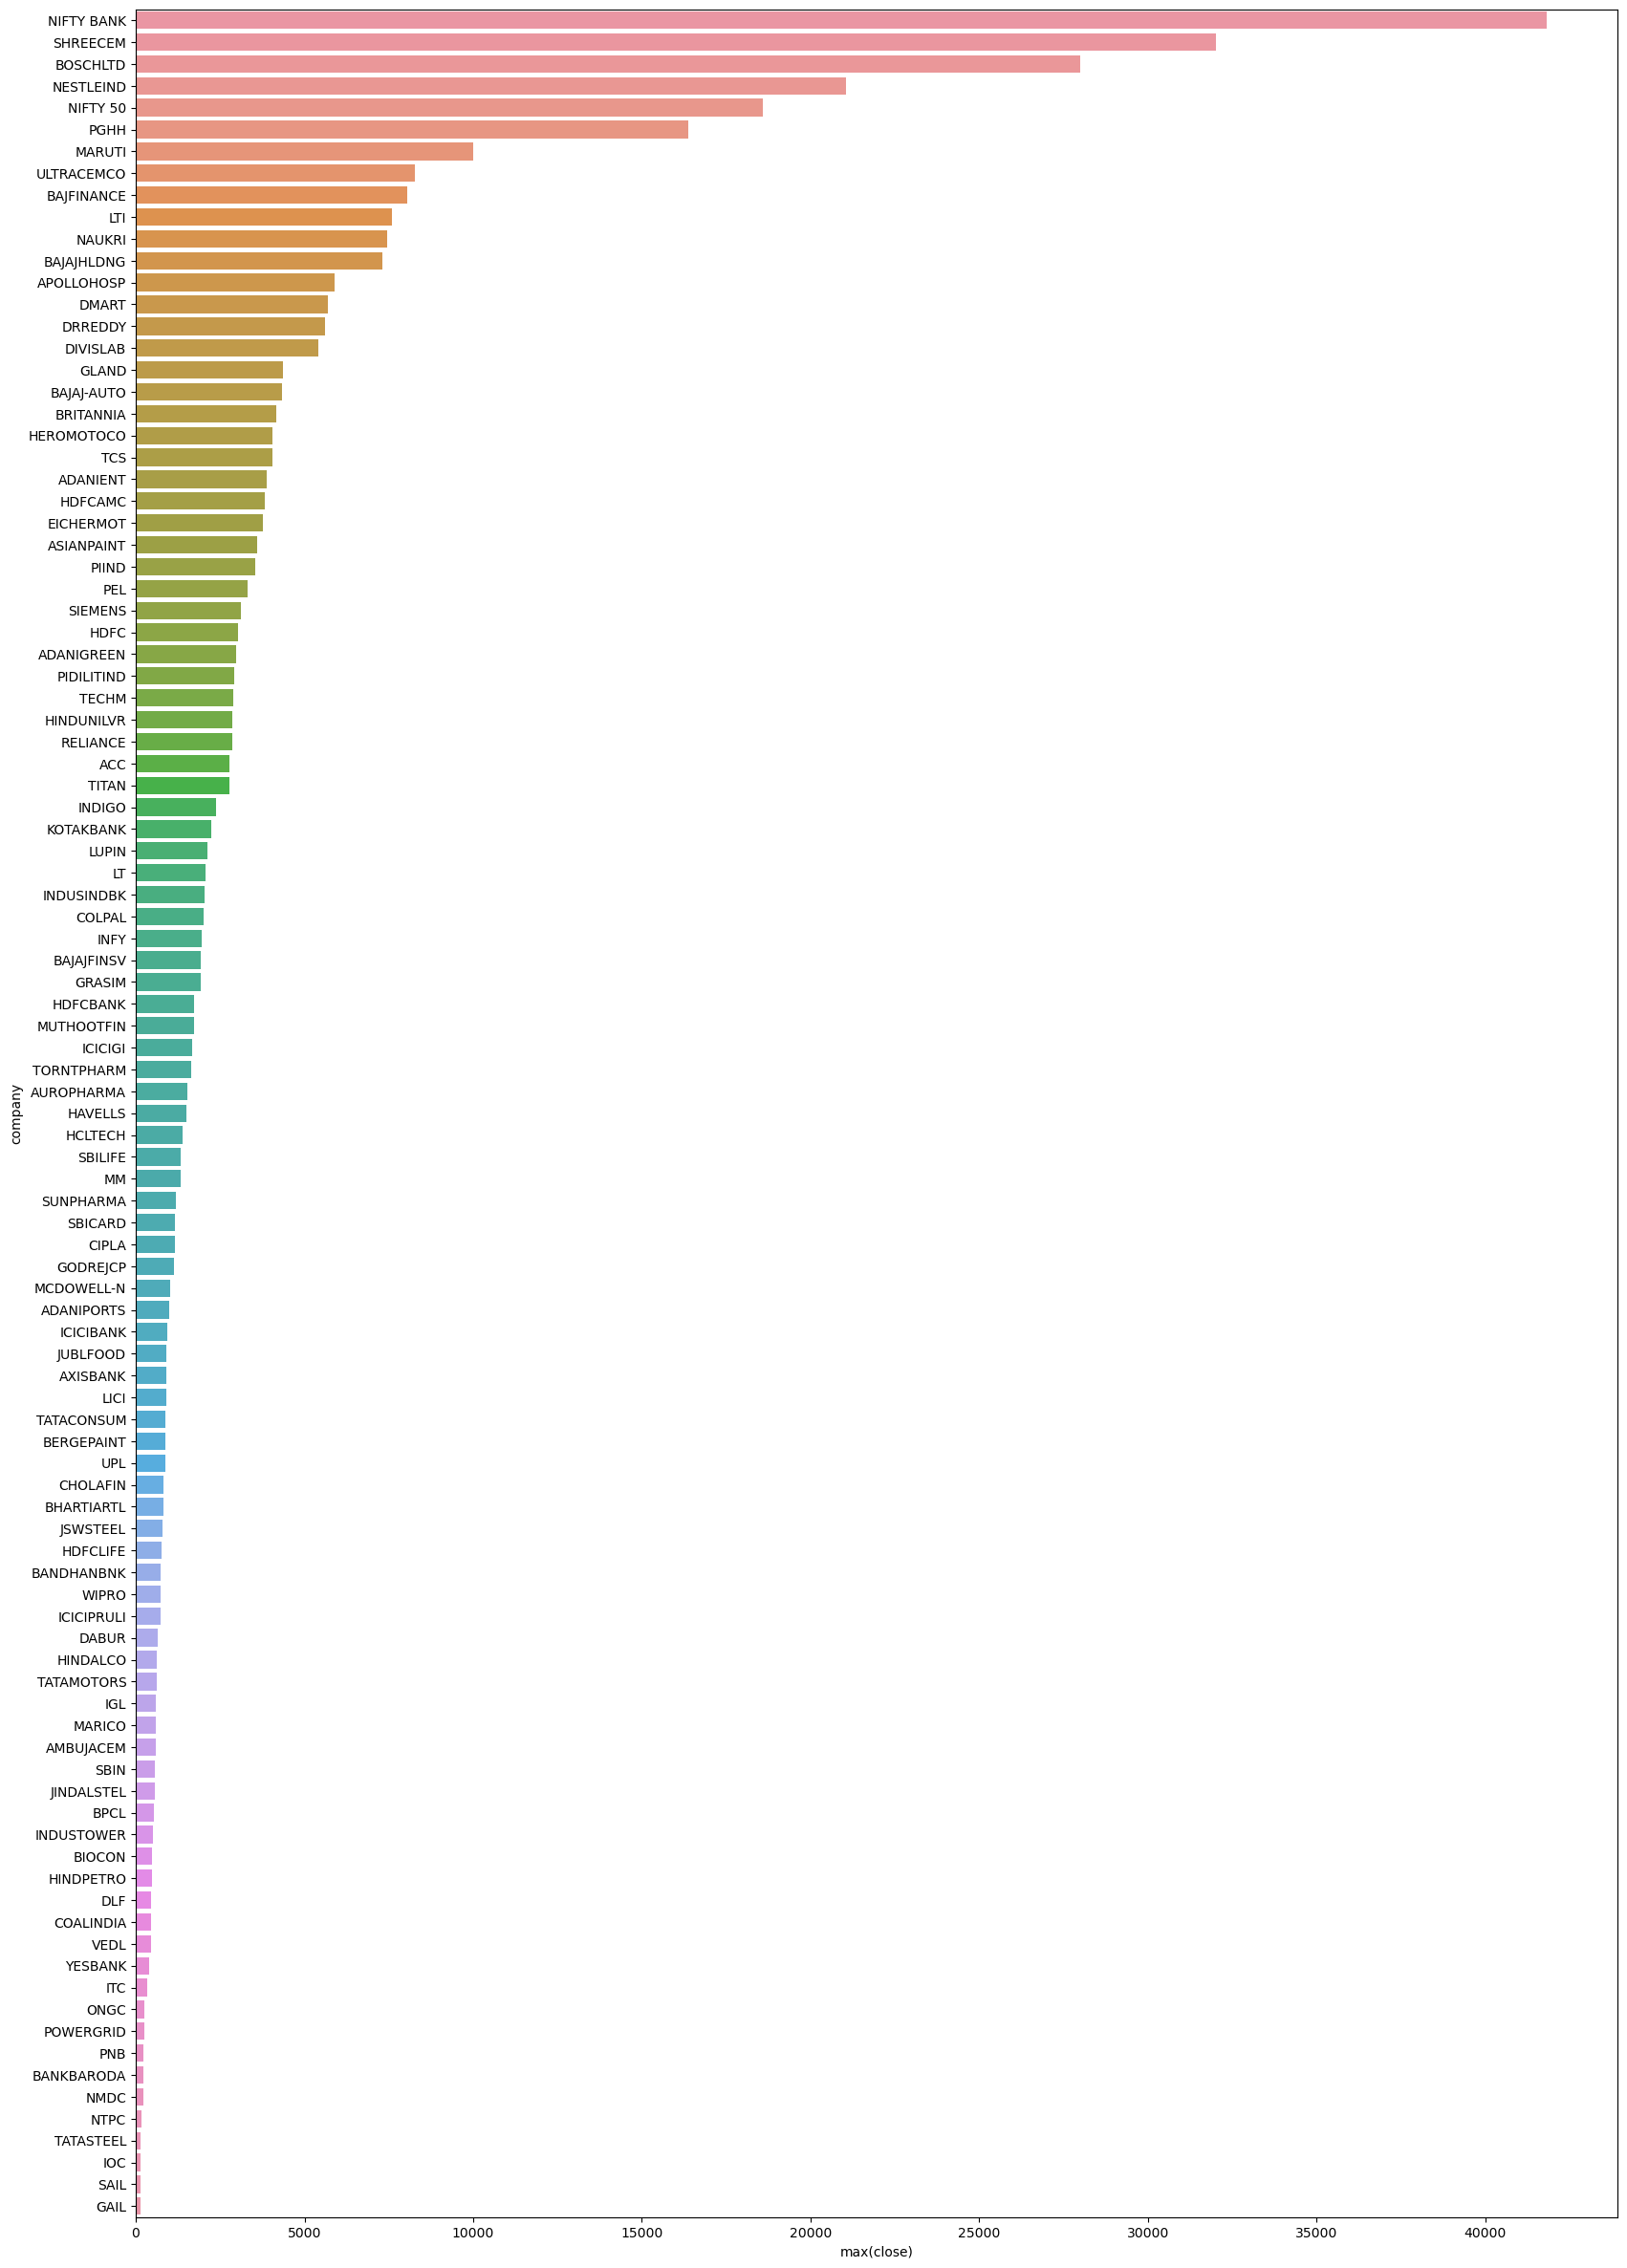

In [22]:
plt.figure(figsize=(20,30))
sns.barplot(data=max_close_df.sort_values(by=['max(close)'],ascending=False), y='company', x='max(close)')

In [9]:
sector_max_df = df.join(df.groupBy(df.sector).agg(max(df.close).alias('close')),on='close',how='leftsemi').toPandas()

22/11/22 00:32:59 WARN org.apache.spark.sql.catalyst.util.package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


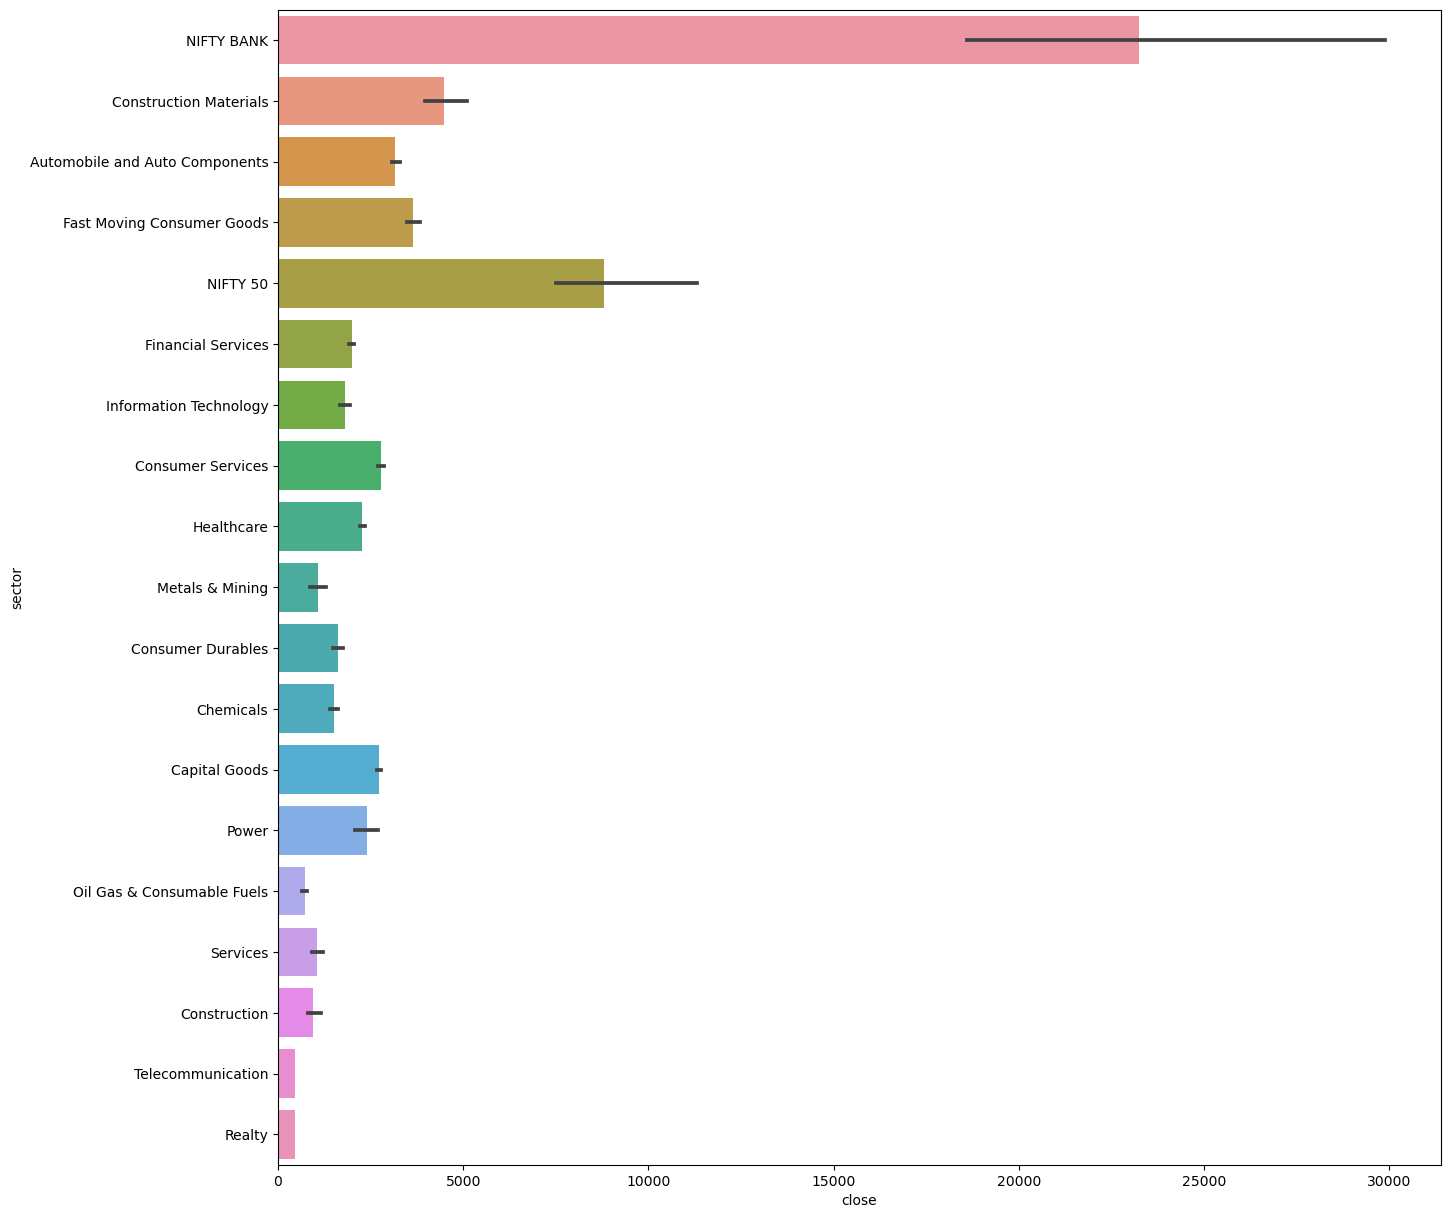

In [10]:
plt.figure(figsize=(15,15))
ax = sns.barplot(data=sector_max_df.sort_values(by=['close'],ascending=False), y='sector', x='close')

In [131]:
from pyspark.sql.types import DateType
def get_month(date):
    return datetime.strptime('{}-{}'.format(date.year, date.month), '%Y-%m')
udf_get_month = udf(get_month, DateType())

df = df.withColumn("month", udf_get_month("date"))
cols = cols = df.columns
cols.remove('month')

exprs = {x: "avg" for x in cols}
exprs["sector"] = "first"

monthly_df = df.groupby(df.company, df.month).agg(exprs)

In [132]:
monthly_df = monthly_df.toPandas()

In [133]:
monthly_df = monthly_df.set_index("month")

In [134]:
monthly_df

,company,avg(RSI14),avg(CCI10),avg(TRIMA10),avg(SAR),avg(fastdsr),avg(ADX20),avg(WILLR),avg(sma10),avg(macd1226),...,avg(HT_TRENDLINE),avg(ULTOSC),avg(ROC5),avg(close),avg(middleband),avg(ROC10),avg(volume),avg(macd1520),avg(high),avg(slowk)
month,,,,,,,,,,,,,,,,,,,,,
2015-02-01,ACC,51.341733,7.375884,1587.842455,1510.245415,50.706838,20.462642,-46.299773,1587.842460,0.122309,...,1587.740189,49.726024,0.005904,1587.924620,1587.888181,0.011817,1479.123302,0.043773,1588.835122,51.792747
2015-04-01,ACC,49.165089,-4.717163,1562.538397,1527.603356,49.967016,22.761690,-51.788365,1562.538568,-0.123961,...,1562.680560,48.220268,-0.005327,1562.463074,1562.496368,-0.010869,944.018818,-0.044448,1563.427103,48.229864
2017-03-01,ACC,49.491401,-6.629445,1410.721791,1772.000000,49.060357,23.565583,-51.454923,1410.721907,0.030574,...,1410.691393,50.377516,0.001747,1410.743097,1410.733421,0.003383,848.907879,0.010859,1411.240836,49.441916
2018-04-01,ACC,49.934429,-0.050633,1556.862298,1174.000000,49.864891,22.186022,-50.747580,1556.862343,0.069887,...,1556.789067,48.100920,0.003296,1556.906273,1556.886430,0.006539,758.506540,0.024970,1557.575086,48.607280
2018-08-01,ACC,50.387066,0.249839,1580.581613,1174.000000,49.369250,22.181563,-50.434503,1580.581623,0.097601,...,1580.514848,49.576885,0.004507,1580.643854,1580.616161,0.009016,1685.264127,0.034871,1581.383302,49.523235
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-03-01,WIPRO,50.869056,1.899614,203.409179,254.510000,48.913123,22.145129,-52.519575,203.409195,0.018019,...,203.386792,47.195326,0.006661,203.421235,203.415820,0.013268,9206.764863,0.006453,203.505826,46.797276
2021-02-01,WIPRO,48.974485,-6.424699,430.330181,153.420000,49.850835,21.081574,-51.149609,430.330068,-0.007771,...,430.330384,52.207062,-0.001331,430.324439,430.327254,-0.002295,30572.976459,-0.002715,430.588386,50.576229
2021-11-01,WIPRO,49.409866,-4.447181,649.182910,153.420000,50.511720,22.025153,-48.169028,649.182902,-0.010443,...,649.197698,55.765572,-0.000866,649.176868,649.179570,-0.001719,13416.473765,-0.003654,649.486514,53.692331


In [39]:
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 62.2 MB/s eta 0:00:0000:010:01


In [24]:
#monthly_df.write.csv('gs://{}/{}'.format(bucket_name, 'month_df.csv'))

In [135]:
import numpy as np
monthly_df_pivot = monthly_df.pivot_table(monthly_df, index=monthly_df.index, columns="company")

In [136]:
monthly_df_pivot

avg(ADX10)                                                         \
company           ACC   ADANIENT ADANIGREEN ADANIPORTS  AMBUJACEM APOLLOHOSP   
month                                                                          
2015-01-01        NaN        NaN        NaN        NaN        NaN        NaN   
2015-02-01  29.212129  27.984075        NaN  28.389499  30.914249  32.740344   
2015-03-01  28.063206  27.835231        NaN  28.680687  28.902737  30.830204   
2015-04-01  30.379855  26.224266        NaN  29.728584  29.057210  31.372386   
2015-05-01  28.029552  29.784022        NaN  30.971609  29.067508  28.544274   
...               ...        ...        ...        ...        ...        ...   
2022-06-01  29.028946  28.646340  28.032352  28.460616  27.909310  29.081421   
2022-07-01  30.346631  28.148449  28.742459  28.074803  33.807316  31.499878   
2022-08-01  29.499986  29.934993  28.420861  29.245243  31.042386  30.543497   
2022-09-01  28.839927  28.352508  29.032998  28.422169  29.584343  30.778732   
2022-10-01  28.504231  28.612552  28.712026  27.985702  28.404658  30.712225   

                                                        ...    avg(volume)  \
company    ASIANPAINT AUROPHARMA   AXISBANK BAJAJ-AUTO  ...      TATASTEEL   
month                                                   ...                  
2015-01-01        NaN        NaN        NaN        NaN  ...            NaN   
2015-02-01  28.698643  28.756438  29.333861  31.511628  ...  120878.723948   
2015-03-01  28.814446  27.787293  28.606512  27.928280  ...  112734.574959   
2015-04-01  29.071282  27.709390  27.860348  29.641694  ...  148832.230024   
2015-05-01  29.202401  27.153061  27.219296  29.465991  ...  125822.219259   
...               ...        ...        ...        ...  ...            ...   
2022-06-01  30.498094  29.742250  29.385212  30.403600  ...  222652.746667   
2022-07-01  31.987689  31.469875  29.456202  28.482143  ...  241248.475810   
2022-08-01  31.215842  29.014221  30.367341  31.068862  ...  182721.136833   
2022-09-01  30.184173  28.796685  30.566900  30.027057  ...  174039.912727   
2022-10-01  31.848918  29.850496  29.123710  31.750400  ...   99378.472881   

                                                                             \
company             TCS         TECHM        TITAN  TORNTPHARM   ULTRACEMCO   
month                                                                         
2015-01-01          NaN           NaN          NaN         NaN          NaN   
2015-02-01  6831.066828   6327.140514  3031.360898  366.293129   527.593384   
2015-03-01  5611.525681   9844.941938  1609.069227  598.971114   932.488462   
2015-04-01  8103.207696   7549.861255  2296.345878  589.395871   894.898048   
2015-05-01  6305.668444  10795.730963  1829.164593  731.611852   944.031852   
...                 ...           ...          ...         ...          ...   
2022-06-01  5950.298386   9014.194947  4810.111860  635.523088  1610.195509   
2022-07-01  7549.254222   8444.968254  4497.249524  840.267810  1132.822349   
2022-08-01  4527.312333   8987.117667  2972.692667  758.623833   974.481500   
2022-09-01  6477.195879   9110.534182  2778.291152  912.432000  1391.683636   
2022-10-01  5357.069115   5349.003202  3733.141996  796.485311  1071.966102   

                                                                     
company              UPL          VEDL         WIPRO        YESBANK  
month                                                                
2015-01-01           NaN           NaN           NaN            NaN  
2015-02-01   6183.567299  10767.144413   8989.817131   48321.848864  
2015-03-01   4079.539080  11408.001935   8963.182969   47606.589251  
2015-04-01   6694.218930  12167.451903  12388.860834   57001.326359  
2015-05-01  12012.445630  15892.809630   9121.625778   32775.057778  
...                  ...           ...           ...            ...  
2022-06-01   5332.474386  32267.352982  19548.810667  110726

In [137]:
df_avg_close = monthly_df_pivot.iloc[:, monthly_df_pivot.columns.get_level_values(0) == 'avg(close)']

In [138]:
import pandas as pd
metric = df_avg_close.columns.get_level_values(0)[0]
returns = pd.DataFrame()
for ticker in df_avg_close.columns.get_level_values(1):
    returns[ticker+ 'Return'] = df_avg_close[(metric, ticker)].pct_change()
returns

,ACCReturn,ADANIENTReturn,ADANIGREENReturn,ADANIPORTSReturn,AMBUJACEMReturn,APOLLOHOSPReturn,ASIANPAINTReturn,AUROPHARMAReturn,AXISBANKReturn,BAJAJ-AUTOReturn,...,TATASTEELReturn,TCSReturn,TECHMReturn,TITANReturn,TORNTPHARMReturn,ULTRACEMCOReturn,UPLReturn,VEDLReturn,WIPROReturn,YESBANKReturn
month,,,,,,,,,,,,,,,,,,,,,
2015-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-02-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2015-03-01,0.012271,-0.052816,NaN,-0.043260,0.001163,0.062088,-0.004426,0.070964,0.010410,-0.080121,...,-0.101817,0.003010,0.129137,-0.065868,0.009976,-0.038280,0.015830,-0.078418,-0.002784,0.013971
2015-04-01,-0.027963,0.023142,NaN,0.012900,-0.038474,-0.051355,-0.006709,0.129121,-0.041251,-0.008380,...,0.054875,-0.025176,-0.207321,0.001579,0.095570,-0.031807,0.059660,0.042813,-0.099006,0.001926
2015-05-01,-0.051098,0.144599,NaN,0.067333,-0.052328,-0.053736,-0.043485,0.020044,0.023670,0.079025,...,0.014509,0.006676,-0.034993,-0.066086,-0.004958,0.007296,0.155496,0.037215,-0.058283,0.031375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-06-01,-0.042440,0.006445,-0.238851,-0.066004,-0.004140,-0.016457,-0.095773,-0.077676,-0.031190,0.019367,...,-0.145802,-0.020521,-0.100795,-0.041168,0.055239,-0.100445,-0.107674,-0.154100,-0.058448,-0.027525
2022-07-01,0.018966,0.102278,0.125354,0.030501,0.014396,0.075739,0.090307,0.035799,0.050072,0.024746,...,-0.059732,-0.043823,-0.047633,0.044864,0.049641,0.083633,-0.026711,-0.158376,-0.076148,0.047099
2022-08-01,0.039770,0.206243,0.096362,0.123077,0.059180,0.081442,0.150198,0.042073,0.084619,0.040407,...,0.188362,0.053980,0.054621,0.125466,0.041536,0.102398,0.099750,0.103888,0.046393,0.192211


In [139]:
# sort stocks by their pct_returns
returns.sum().sort_values(ascending=False)

ADANIGREENReturn    5.554021
ADANIENTReturn      3.425333
BAJFINANCEReturn    3.385673
BAJAJFINSVReturn    2.940051
CHOLAFINReturn      2.330006
                      ...   
LICIReturn         -0.291534
INDUSTOWERReturn   -0.390020
LUPINReturn        -0.606778
PNBReturn          -0.927736
YESBANKReturn      -1.499328
Length: 101, dtype: float64

In [144]:
# sort stocks by their pct returns prior to covid
returns[returns.index < datetime.strptime('2020-03', '%Y-%m').date()].sum().sort_values(ascending=False)

BAJFINANCEReturn    2.620315
ADANIGREENReturn    2.536036
BAJAJFINSVReturn    2.063957
IGLReturn           1.857979
BIOCONReturn        1.616812
                      ...   
ONGCReturn         -0.662669
LUPINReturn        -0.707988
PNBReturn          -0.729324
YESBANKReturn      -0.894323
TATAMOTORSReturn   -0.916586
Length: 101, dtype: float64

In [145]:
# sort stocks by their pct returns after covid
returns[returns.index >= datetime.strptime('2020-03', '%Y-%m').date()].sum().sort_values(ascending=False)

ADANIENTReturn      3.056183
ADANIGREENReturn    3.017985
TATAMOTORSReturn    1.345978
JINDALSTELReturn    1.301671
JSWSTEELReturn      1.111649
                      ...   
PELReturn          -0.200259
LICIReturn         -0.291534
BPCLReturn         -0.339811
HDFCAMCReturn      -0.432918
YESBANKReturn      -0.605005
Length: 101, dtype: float64

In [146]:
# Worst Single Day Drops
returns.idxmin()

ACCReturn           2020-03-01
ADANIENTReturn      2015-06-01
ADANIGREENReturn    2018-10-01
ADANIPORTSReturn    2020-03-01
AMBUJACEMReturn     2020-03-01
                       ...    
ULTRACEMCOReturn    2020-03-01
UPLReturn           2020-03-01
VEDLReturn          2020-03-01
WIPROReturn         2020-03-01
YESBANKReturn       2019-05-01
Length: 101, dtype: object

In [147]:
# Best Single Day Mins
returns.idxmax()

ACCReturn           2018-08-01
ADANIENTReturn      2018-08-01
ADANIGREENReturn    2018-08-01
ADANIPORTSReturn    2020-12-01
AMBUJACEMReturn     2022-09-01
                       ...    
ULTRACEMCOReturn    2021-02-01
UPLReturn           2018-11-01
VEDLReturn          2020-12-01
WIPROReturn         2021-01-01
YESBANKReturn       2019-11-01
Length: 101, dtype: object

In [148]:
# Sorting stocks from safest to riskiet
returns.std().sort_values()

PGHHReturn          0.040811
NIFTY 50Return      0.041853
POWERGRIDReturn     0.044276
HDFCBANKReturn      0.048348
COLPALReturn        0.048673
                      ...   
YESBANKReturn       0.128395
TATAMOTORSReturn    0.130740
JINDALSTELReturn    0.152410
ADANIENTReturn      0.172483
ADANIGREENReturn    0.219325
Length: 101, dtype: float64

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='ADANIGREENReturn', ylabel='Density'>

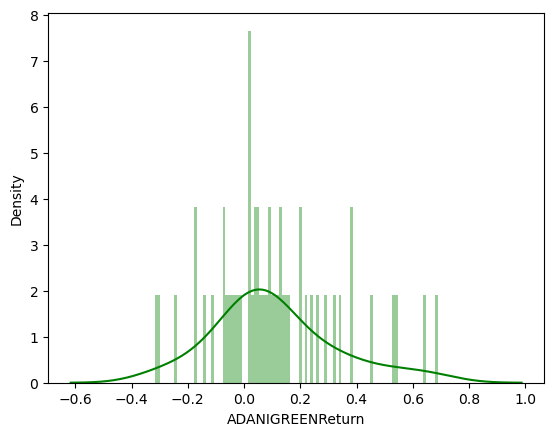

In [149]:
# Plotting distplot for the riskiest stock ADANIGREEN
sns.distplot(returns['ADANIGREENReturn'],color='green',bins=100)

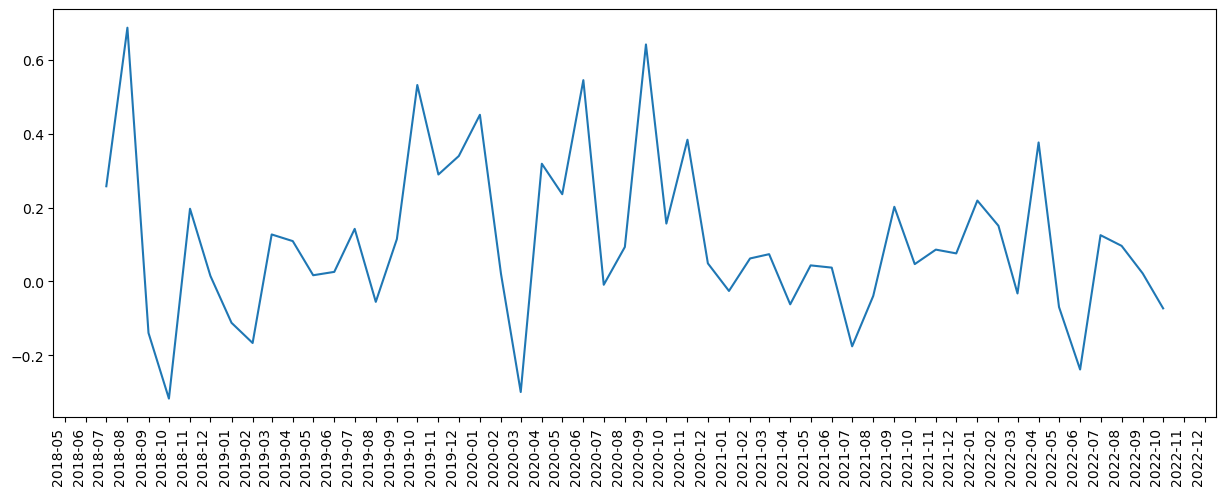

In [151]:
# Lineplot for riskiest stock ADANIGREEN
from matplotlib import dates
formatter = dates.DateFormatter('%Y-%m')

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(returns['ADANIGREENReturn'])

#ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=90)
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='PGHHReturn', ylabel='Density'>

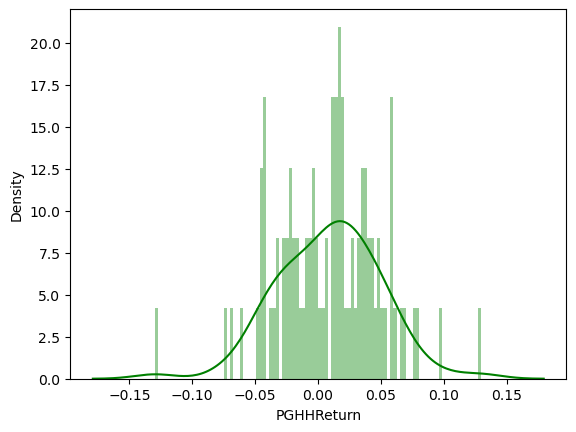

In [152]:
# Plotting distplot for the safest stock PGHH
sns.distplot(returns['PGHHReturn'],color='green',bins=100)

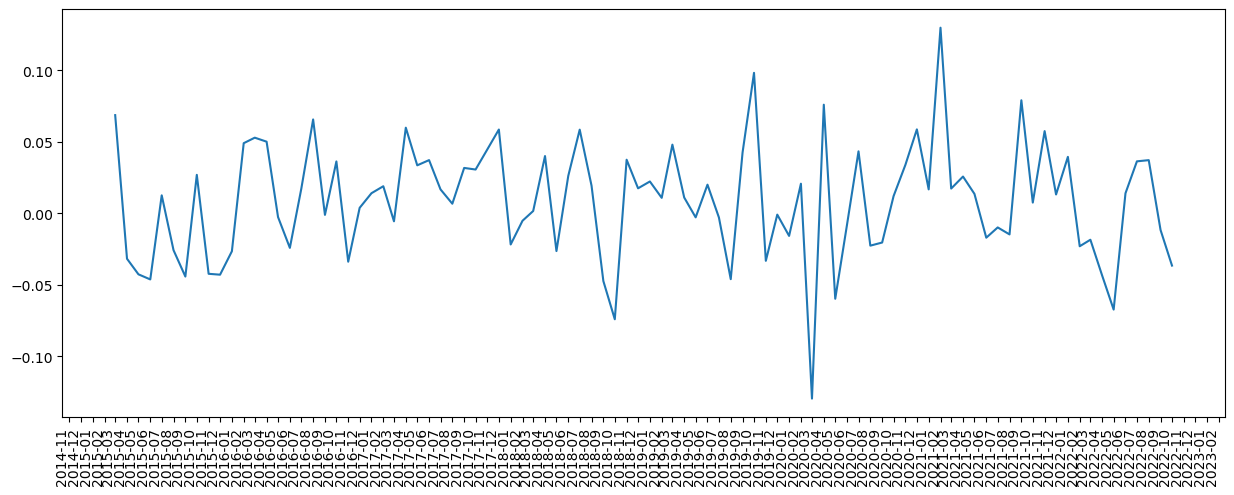

In [155]:
# Lineplot for safest stock PGHH
from matplotlib import dates
formatter = dates.DateFormatter('%Y-%m')

fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(returns['PGHHReturn'])

#ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=90)
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))

In [158]:
!pip install cufflinks

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.7/81.7 kB 4.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.7/247.7 kB 15.0 MB/s eta 0:00:00
  Created wheel for cufflinks: filename=cufflinks-0.17.3-py3-none-any.whl size=67918 sha256=55fefe531ccb105df216b34f7b2dfaa04ca2a07ddfd88cc756f6928fa9b6aef9
  Stored in directory: /root/.cache/pip/wheels/8b/0c/8c/6b052b6e9281a66c0618959319eb404b1ae6dba84c5505a4c6
Successfully built cufflinks
  Attempting uninstall: python-dateutil
    Found existing installation: python-dateutil 2.8.0
    Uninstalling python-dateutil-2.8.0:
      Successfully uninstalled python-dateutil-2.8.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
pysal 2.4.0 requires python-dateutil<=2.8.0, but you have python-dateutil 2.8.2 which is incompatible.
pysal 2.4.0 requires urllib3>=1.26, but

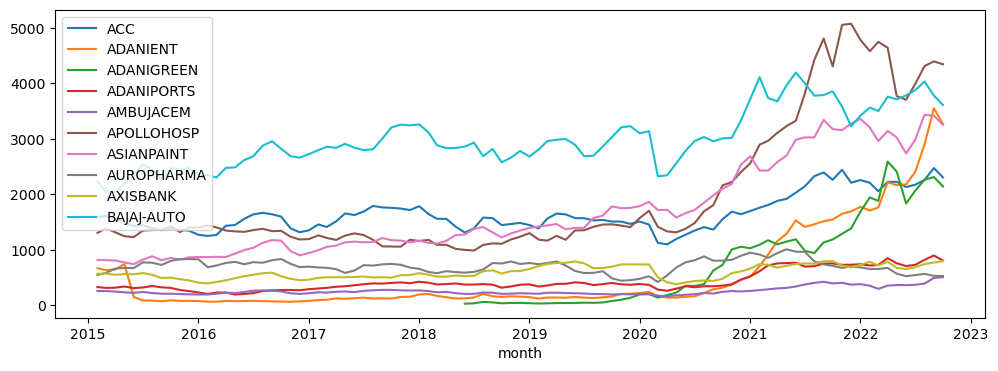

In [164]:
# Avg close of the top 10 stocks by returns
import plotly
import cufflinks as cf
cf.go_offline()
metric = df_avg_close.columns.get_level_values(0)[0]

for ticker in df_avg_close.columns.get_level_values(1):
    if ticker+'Return' in returns.idxmax()[0:10].index:
        df_avg_close[(metric, ticker)].plot(figsize=(12,4),label=ticker)
plt.legend()

In [177]:
# Interactive plot for Avg close of the top 10 stocks by returns
import plotly
import cufflinks as cf
cf.go_offline()
metric = df_avg_close.columns.get_level_values(0)[0]

top_10_stocks = [(metric, x[:-6]) for x in returns.idxmax()[0:10].index]
df_avg_close[top_10_stocks].iplot()

In [185]:
cols = cols = df.columns
cols.remove('month')
cols.remove('company')

exprs = {x: "avg" for x in cols}

sector_monthly_df = df.groupBy(df.sector, df.month).agg(exprs).toPandas()

In [186]:
sector_monthly_df

,sector,month,avg(RSI14),avg(CCI10),avg(TRIMA10),avg(SAR),avg(fastdsr),avg(ADX20),avg(WILLR),avg(sma10),...,avg(HT_TRENDLINE),avg(ULTOSC),avg(ROC5),avg(close),avg(middleband),avg(ROC10),avg(volume),avg(macd1520),avg(high),avg(slowk)
0,Power,2019-05-01,49.502751,-3.565908,104.048453,67.585365,49.783195,26.410991,-48.713563,104.048450,...,104.044454,52.765694,0.002366,104.049243,104.048881,0.004677,17328.731046,0.000505,104.106613,52.177343
1,Power,2018-11-01,50.090607,-2.807179,103.648307,67.496667,49.864941,24.859254,-46.964023,103.648297,...,103.648845,47.450193,0.002606,103.646538,103.647338,0.005460,9869.294166,-0.000992,103.704268,47.815863
2,Power,2021-03-01,49.437224,-4.002789,469.480725,91.223774,49.615210,22.805272,-50.055889,469.480815,...,469.476204,51.033057,-0.000394,469.470013,469.474752,-0.000889,43437.272906,-0.006776,469.858518,50.159273
3,Consumer Durables,2019-12-01,49.958778,-1.608121,1022.015162,336.612500,49.369091,22.123185,-50.981575,1022.015231,...,1021.973285,49.709965,0.001576,1022.032833,1022.024802,0.003055,3443.831474,0.009733,1022.444584,49.141252
4,Financial Services,2018-12-01,50.144559,-0.444956,878.179225,419.155269,49.602887,22.707899,-49.811627,878.179181,...,878.147791,50.218705,0.003322,878.201065,878.191425,0.006687,19568.097327,0.012473,878.665764,49.921306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1764,Chemicals,2022-03-01,50.613511,1.081615,1924.701522,248.901611,49.626578,21.905864,-48.479898,1924.701564,...,1924.609663,51.582446,0.006645,1924.797759,1924.755064,0.013253,4198.832839,0.053983,1926.077692,51.065991
1765,Realty,2022-08-01,49.744537,-2.761035,375.314966,72.450000,48.764817,21.840565,-50.709341,375.314983,...,375.313830,50.535911,0.001347,375.318950,375.317143,0.002671,12687.921000,0.001619,375.545442,49.480559
1766,Services,2015-11-01,49.522036,-2.584153,557.251578,543.621302,49.563072,21.927927,-51.115928,557.251721,...,557.028506,49.463768,0.008276,557.352940,557.307698,0.016370,10641.057573,0.057096,557.880320,49.151758
1767,Services,2016-03-01,50.487481,-1.796955,522.042152,858.143939,48.523031,21.242028,-51.714214,522.042051,...,521.953413,48.022721,0.013855,522.090372,522.069071,0.027892,5774.364283,0.027918,522.523325,47.665924


In [183]:
col_earlist_date = min('date').alias('earliest')
col_latest_date = max('date').alias('latest')
df_result = df.select(col_earlist_date, col_latest_date)
df_result.show()

+-------------------+-------------------+
|           earliest|             latest|
+-------------------+-------------------+
|2015-01-09 10:18:00|2022-10-25 12:31:00|
+-------------------+-------------------+



In [187]:
sector_monthly_df.set_index("month", inplace=True)
sector_monthly_df

,sector,avg(RSI14),avg(CCI10),avg(TRIMA10),avg(SAR),avg(fastdsr),avg(ADX20),avg(WILLR),avg(sma10),avg(macd1226),...,avg(HT_TRENDLINE),avg(ULTOSC),avg(ROC5),avg(close),avg(middleband),avg(ROC10),avg(volume),avg(macd1520),avg(high),avg(slowk)
month,,,,,,,,,,,,,,,,,,,,,
2019-05-01,Power,49.502751,-3.565908,104.048453,67.585365,49.783195,26.410991,-48.713563,104.048450,0.001433,...,104.044454,52.765694,0.002366,104.049243,104.048881,0.004677,17328.731046,0.000505,104.106613,52.177343
2018-11-01,Power,50.090607,-2.807179,103.648307,67.496667,49.864941,24.859254,-46.964023,103.648297,-0.002789,...,103.648845,47.450193,0.002606,103.646538,103.647338,0.005460,9869.294166,-0.000992,103.704268,47.815863
2021-03-01,Power,49.437224,-4.002789,469.480725,91.223774,49.615210,22.805272,-50.055889,469.480815,-0.018906,...,469.476204,51.033057,-0.000394,469.470013,469.474752,-0.000889,43437.272906,-0.006776,469.858518,50.159273
2019-12-01,Consumer Durables,49.958778,-1.608121,1022.015162,336.612500,49.369091,22.123185,-50.981575,1022.015231,0.027493,...,1021.973285,49.709965,0.001576,1022.032833,1022.024802,0.003055,3443.831474,0.009733,1022.444584,49.141252
2018-12-01,Financial Services,50.144559,-0.444956,878.179225,419.155269,49.602887,22.707899,-49.811627,878.179181,0.034959,...,878.147791,50.218705,0.003322,878.201065,878.191425,0.006687,19568.097327,0.012473,878.665764,49.921306
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-03-01,Chemicals,50.613511,1.081615,1924.701522,248.901611,49.626578,21.905864,-48.479898,1924.701564,0.151358,...,1924.609663,51.582446,0.006645,1924.797759,1924.755064,0.013253,4198.832839,0.053983,1926.077692,51.065991
2022-08-01,Realty,49.744537,-2.761035,375.314966,72.450000,48.764817,21.840565,-50.709341,375.314983,0.004435,...,375.313830,50.535911,0.001347,375.318950,375.317143,0.002671,12687.921000,0.001619,375.545442,49.480559
2015-11-01,Services,49.522036,-2.584153,557.251578,543.621302,49.563072,21.927927,-51.115928,557.251721,0.160434,...,557.028506,49.463768,0.008276,557.352940,557.307698,0.016370,10641.057573,0.057096,557.880320,49.151758


In [201]:
metric = df_avg_close.columns.get_level_values(0)[0]
returns_sector = pd.DataFrame()
for sector in sector_monthly_df['sector'].unique():
    returns_sector[sector+ 'Return'] = sector_monthly_df[sector_monthly_df['sector'] == sector]['avg(close)'].pct_change()
returns_sector

,PowerReturn,Consumer DurablesReturn,Financial ServicesReturn,TelecommunicationReturn,Oil Gas & Consumable FuelsReturn,HealthcareReturn,Fast Moving Consumer GoodsReturn,ConstructionReturn,Automobile and Auto ComponentsReturn,Consumer ServicesReturn,NIFTY BANKReturn,Construction MaterialsReturn,ServicesReturn,RealtyReturn,Information TechnologyReturn,Metals & MiningReturn,ChemicalsReturn,Capital GoodsReturn,NIFTY 50Return
month,,,,,,,,,,,,,,,,,,,
2019-05-01,NaN,-0.059507,0.163583,-0.136949,-0.015223,0.092629,-0.212476,-0.072004,-0.134774,0.890452,0.116073,-0.269936,0.203629,-0.047982,0.059316,-0.171680,-0.021778,-0.029804,-0.005780
2018-11-01,-0.003870,0.534121,0.567552,-0.291648,-0.012605,-0.479692,-0.062984,0.079136,0.117652,-0.085496,-0.074778,-0.133805,-0.206235,-0.028086,0.537456,-0.679145,0.014081,-0.147863,0.227530
2021-03-01,3.529529,-0.279358,1.706729,0.209411,-0.021758,-0.219819,-0.115354,0.628198,-0.034783,0.816111,0.607540,0.342647,0.723887,0.405807,-0.017345,-0.334862,-0.266958,0.483822,0.838990
2017-01-01,-0.693159,-0.300185,-0.275859,0.106646,-0.102104,NaN,-0.386415,-0.284151,0.090397,-0.671685,-0.349178,-0.088543,-0.295862,-0.144884,-0.787455,-0.260125,-0.188895,-0.021312,-0.236020
2022-01-01,3.703623,0.219128,1.608137,0.255739,0.865304,1.022493,1.497263,0.288453,0.289407,-0.124720,1.134778,0.533068,0.045317,0.025280,0.068914,-0.247265,1.725367,0.006488,0.011541
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-10-01,0.021670,0.631088,0.029410,0.185879,-0.182666,-0.420020,0.252863,0.142633,-0.042399,0.455909,0.347453,0.271595,-0.004987,-0.045701,-0.672212,-0.642687,0.079773,0.063239,0.029400
2015-05-01,-0.270670,-0.027902,-0.555588,0.130497,0.030207,-0.479068,-0.559414,-0.245366,-0.083186,-0.026165,0.089330,-0.533436,-0.715100,-0.202346,-0.770662,-0.680257,-0.730681,0.079296,-0.531940
2016-04-01,-0.006349,0.061524,-0.361766,-0.182973,0.018988,-0.403325,-0.145751,-0.088925,-0.093016,-0.577028,-0.112935,0.095873,-0.318301,0.126234,-0.420543,-0.451494,0.039437,-0.026795,-0.280170


In [219]:
returns_sector.sort_index(inplace=True)

In [220]:
# Sort sector by returns
returns_sector.sum().sort_values(ascending=False)

PowerReturn                             41.281636
Consumer ServicesReturn                 34.324299
Metals & MiningReturn                   34.168266
Consumer DurablesReturn                 20.479379
Information TechnologyReturn            15.460064
ChemicalsReturn                         14.139657
Fast Moving Consumer GoodsReturn        10.905082
ServicesReturn                          10.475123
Financial ServicesReturn                10.033230
RealtyReturn                             9.317621
Capital GoodsReturn                      7.242271
Construction MaterialsReturn             5.836829
HealthcareReturn                         5.167333
Oil Gas & Consumable FuelsReturn         5.160734
NIFTY BANKReturn                         4.896408
NIFTY 50Return                           4.795767
ConstructionReturn                       4.019007
TelecommunicationReturn                  1.811306
Automobile and Auto ComponentsReturn     1.020217
dtype: float64

In [221]:
# Sort sector by returns prior to covid
returns_sector[returns_sector.index < datetime.strptime('2020-03', '%Y-%m').date()].sum().sort_values(ascending=False)

Automobile and Auto ComponentsReturn    2.574699
NIFTY BANKReturn                       -0.004774
TelecommunicationReturn                -0.997478
RealtyReturn                           -1.384002
ConstructionReturn                     -1.549462
Oil Gas & Consumable FuelsReturn       -1.642349
Financial ServicesReturn               -2.199151
ChemicalsReturn                        -2.325792
ServicesReturn                         -2.811877
NIFTY 50Return                         -3.818294
Metals & MiningReturn                  -4.694309
Construction MaterialsReturn           -4.889107
Consumer ServicesReturn                -5.085343
Capital GoodsReturn                    -5.090625
Information TechnologyReturn           -5.478289
HealthcareReturn                       -6.130081
Consumer DurablesReturn                -7.097158
Fast Moving Consumer GoodsReturn       -7.456480
PowerReturn                            -8.264031
dtype: float64

In [222]:
# Sort sector by returns after covid
returns_sector[returns_sector.index >= datetime.strptime('2020-03', '%Y-%m').date()].sum().sort_values(ascending=False)

PowerReturn                             49.545666
Consumer ServicesReturn                 39.409641
Metals & MiningReturn                   38.862576
Consumer DurablesReturn                 27.576537
Information TechnologyReturn            20.938352
Fast Moving Consumer GoodsReturn        18.361562
ChemicalsReturn                         16.465449
ServicesReturn                          13.287000
Capital GoodsReturn                     12.332897
Financial ServicesReturn                12.232381
HealthcareReturn                        11.297414
Construction MaterialsReturn            10.725936
RealtyReturn                            10.701624
NIFTY 50Return                           8.614061
Oil Gas & Consumable FuelsReturn         6.803083
ConstructionReturn                       5.568469
NIFTY BANKReturn                         4.901183
TelecommunicationReturn                  2.808784
Automobile and Auto ComponentsReturn    -1.554482
dtype: float64

In [223]:
# Worst single day drops sector wise
returns_sector.idxmin()

PowerReturn                             2019-10-01
Consumer DurablesReturn                 2015-10-01
Financial ServicesReturn                2016-03-01
TelecommunicationReturn                 2019-08-01
Oil Gas & Consumable FuelsReturn        2015-10-01
HealthcareReturn                        2018-04-01
Fast Moving Consumer GoodsReturn        2015-12-01
ConstructionReturn                      2016-02-01
Automobile and Auto ComponentsReturn    2020-05-01
Consumer ServicesReturn                 2015-08-01
NIFTY BANKReturn                        2016-06-01
Construction MaterialsReturn            2015-11-01
ServicesReturn                          2015-05-01
RealtyReturn                            2016-05-01
Information TechnologyReturn            2017-01-01
Metals & MiningReturn                   2015-12-01
ChemicalsReturn                         2015-09-01
Capital GoodsReturn                     2019-03-01
NIFTY 50Return                          2015-05-01
dtype: object

In [224]:
# Best single day gains sector wise
returns_sector.idxmax()

PowerReturn                             2022-07-01
Consumer DurablesReturn                 2022-05-01
Financial ServicesReturn                2022-03-01
TelecommunicationReturn                 2021-10-01
Oil Gas & Consumable FuelsReturn        2021-09-01
HealthcareReturn                        2022-03-01
Fast Moving Consumer GoodsReturn        2022-03-01
ConstructionReturn                      2022-03-01
Automobile and Auto ComponentsReturn    2017-05-01
Consumer ServicesReturn                 2022-02-01
NIFTY BANKReturn                        2022-01-01
Construction MaterialsReturn            2021-07-01
ServicesReturn                          2021-05-01
RealtyReturn                            2022-05-01
Information TechnologyReturn            2022-02-01
Metals & MiningReturn                   2021-06-01
ChemicalsReturn                         2022-09-01
Capital GoodsReturn                     2021-10-01
NIFTY 50Return                          2021-12-01
dtype: object

In [225]:
# Soting sectors from safest to riskiest
returns_sector.std().sort_values()

Automobile and Auto ComponentsReturn    0.165776
TelecommunicationReturn                 0.198903
ConstructionReturn                      0.301832
NIFTY BANKReturn                        0.324998
NIFTY 50Return                          0.345616
Oil Gas & Consumable FuelsReturn        0.357791
HealthcareReturn                        0.358289
Construction MaterialsReturn            0.382126
Capital GoodsReturn                     0.420600
RealtyReturn                            0.466559
Financial ServicesReturn                0.542643
ServicesReturn                          0.558518
Fast Moving Consumer GoodsReturn        0.559766
ChemicalsReturn                         0.630045
Information TechnologyReturn            0.741170
Consumer DurablesReturn                 0.818572
Metals & MiningReturn                   1.249175
Consumer ServicesReturn                 1.253748
PowerReturn                             1.419245
dtype: float64

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='PowerReturn', ylabel='Density'>

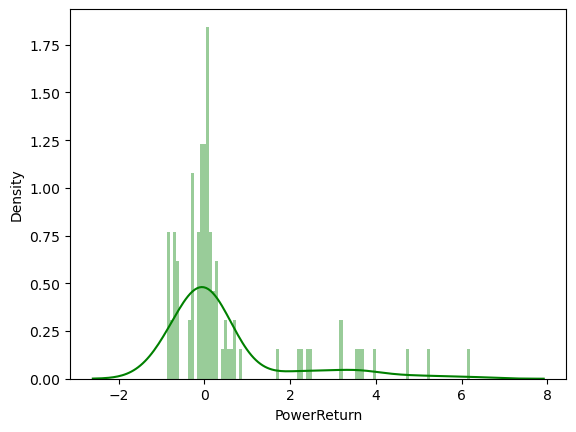

In [226]:
# Plotting the riskiest sector
sns.distplot(returns_sector['PowerReturn'],color='green',bins=100)

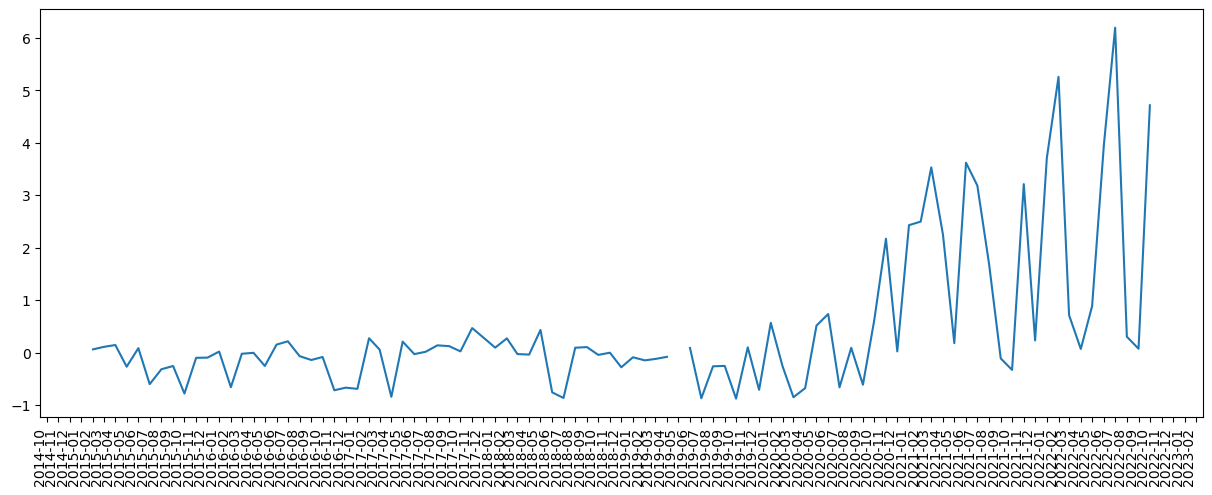

In [228]:
# Lineplot for the riskiest sector
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(returns_sector['PowerReturn'])

#ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=90)
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))

/opt/conda/miniconda3/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).



<AxesSubplot:xlabel='Automobile and Auto ComponentsReturn', ylabel='Density'>

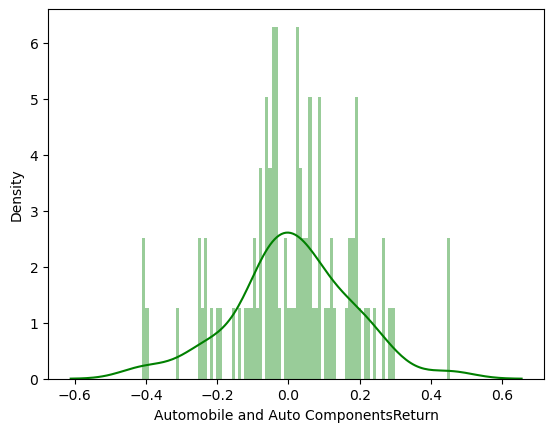

In [229]:
# Plotting the safest sector
sns.distplot(returns_sector['Automobile and Auto ComponentsReturn'],color='green',bins=100)

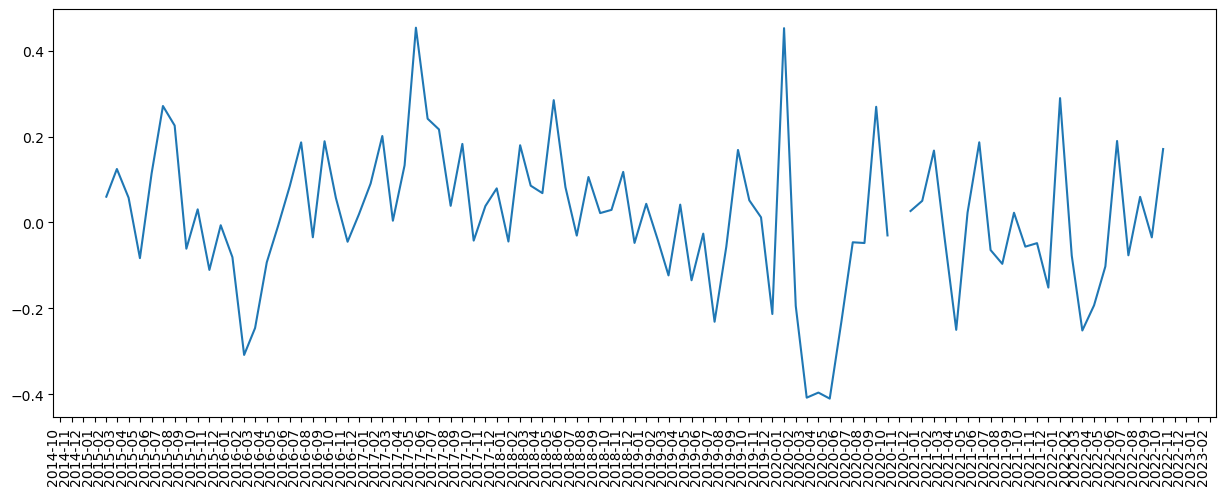

In [230]:
# Lineplot for the safest sector
fig, ax = plt.subplots(figsize=(15, 6))

plt.plot(returns_sector['Automobile and Auto ComponentsReturn'])

#ax.xaxis.set_major_formatter(formatter)
plt.gcf().autofmt_xdate(rotation=90)
ax.xaxis.set_major_locator(dates.MonthLocator(interval=1))

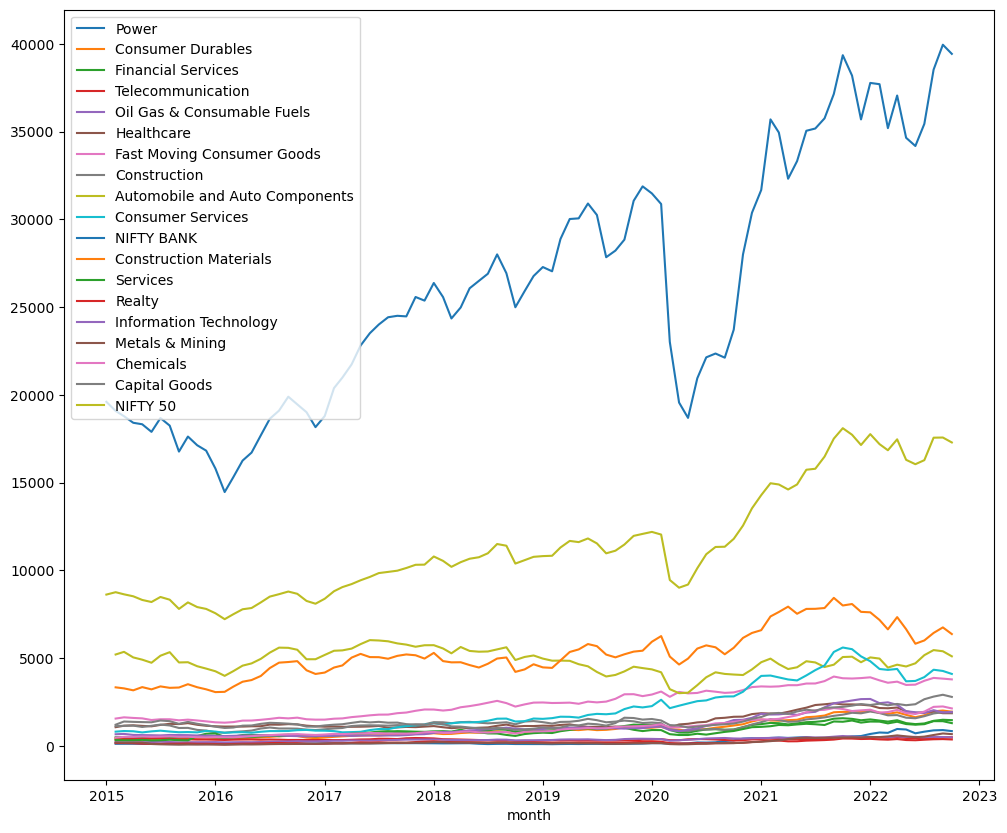

In [235]:
# Plotting top 10 sectors by return
for sector in sector_monthly_df['sector'].unique():
    sector_monthly_df[sector_monthly_df['sector']==sector]['avg(close)'].plot(figsize=(12,10),label=sector)
plt.legend()

In [238]:
power_sector_df = df.filter(df.sector == 'Power').groupby(df.company, df.month).agg(exprs).toPandas().set_index('month')

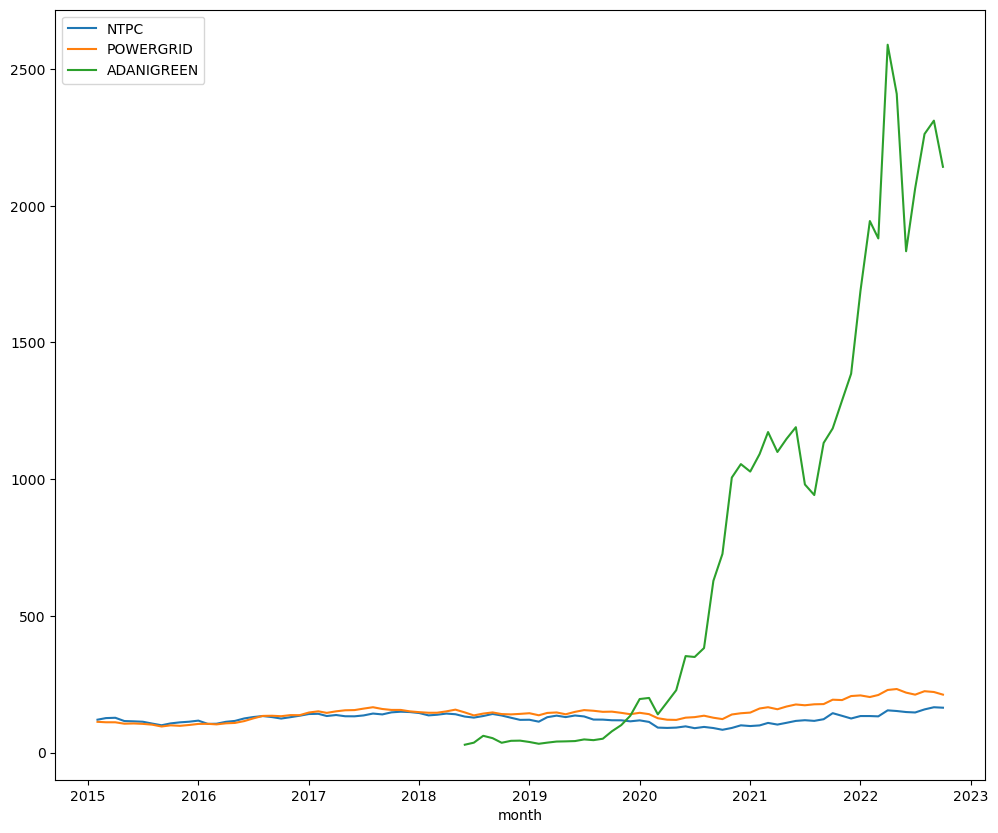

In [243]:
# Plotting time series for all power sector companies
for company in power_sector_df['company'].unique():
    power_sector_df[power_sector_df['company']==company]['avg(close)'].plot(figsize=(12,10),label=company)
plt.legend()